# **Initial Information**
---
The following dataset uses 132 URLs and obtains information pertaining to NVDA's stock, utilizing Google Search engine for our API Search. The following data's sentiments for every sentence has yet to be evaluated, and was pre-assigned sentiments based on Fin-BERT, a transformer-based sentiment classifier.


# **Motley DataSet Cleanup**
---
The following is used to clean the forbes CSV file, and will be used as a blueprint for new data.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import re

df = pd.read_csv("Scrapersandrawfiles/MotleyFoolData/nvda_sentence_sentiment_dataset.csv")
df.head()

,url,date,case_text,label,score,score_positive,score_neutral,score_negative,numeric_label
0,https://www.fool.com/investing/2022/01/10/why-nvidia-stock-soared-in-2021/,2022-01-10T10:20:33-05:00,"Founded in 1993, The Motley Fool is a financial services company dedicated to making the world smarter, happier, and richer. The Motley Fool reaches millions of people every month through our premium investing solutions, free guidance and market analysis on Fool.com, top-rated podcasts, and non-profit The Motley Fool Foundation. Founded in 1993, The Motley Fool is a financial services company dedicated to making the world smarter, happier, and richer.",neutral,0.919492,0.065100,0.919492,0.015408,0
1,https://www.fool.com/investing/2022/01/10/why-nvidia-stock-soared-in-2021/,2022-01-10T10:20:33-05:00,"The Motley Fool reaches millions of people every month through our premium investing solutions, free guidance and market analysis on Fool.com, personal finance education, top-rated podcasts, and non-profit The Motley Fool Foundation. Founded in 1993, The Motley Fool is a financial services company dedicated to making the world smarter, happier, and richer.",neutral,0.855451,0.134116,0.855451,0.010433,0
2,https://www.fool.com/investing/2022/01/10/why-nvidia-stock-soared-in-2021/,2022-01-10T10:20:33-05:00,"The Motley Fool reaches millions of people every month through our premium investing solutions, free guidance and market analysis on Fool.com, top-rated podcasts, and non-profit The Motley Fool Foundation. Founded in 1993, The Motley Fool is a financial services company dedicated to making the world smarter, happier, and richer. The Motley Fool reaches millions of people every month through our premium investing solutions, free guidance and market analysis on Fool.com, personal finance education, top-rated podcasts, and non-profit The Motley Fool Foundation.",neutral,0.873373,0.115334,0.873373,0.011292,0
3,https://www.fool.com/investing/2022/01/10/why-nvidia-stock-soared-in-2021/,2022-01-10T10:20:33-05:00,"You're reading a free article with opinions that may differ\r\n from The Motley Fool's Premium Investing Services. Become a Motley Fool member today to\r\n get instant access to our top analyst recommendations, in-depth research, investing resources,\r\n and more.",neutral,0.844963,0.144721,0.844963,0.010316,0
4,https://www.fool.com/investing/2022/01/10/why-nvidia-stock-soared-in-2021/,2022-01-10T10:20:33-05:00,"Learn More\r\n Key Points A late-year surge in Nvidia shares came as investors and analysts recognized a new catalyst ahead. 2021 was a big, and transitional, year for specialty semiconductor chip company Nvidia (NVDA -0.96%). The company mostly known for gaming and graphics cards evolved over the course of the year, and investors took notice.",positive,0.938613,0.938613,0.041304,0.020083,1


Checking Unique URLS: (total successful scrapes out of 493)

In [14]:
unique_urls = df['url'].nunique()
print("Unique URLs:", unique_urls)

Unique URLs: 493


That's more like it.



## **Date Time Corrections**
---
I noticed discrepencies when loading in the correct data for dates. We will be exploring and correcting these.

In [15]:
print(df.dtypes)
df['date'] = df['date'].astype(str)
print(df.head())
print(df.shape[0])

url                object
date               object
case_text          object
label              object
score             float64
score_positive    float64
score_neutral     float64
score_negative    float64
numeric_label       int64
dtype: object
                                                                          url  \
0  https://www.fool.com/investing/2022/01/10/why-nvidia-stock-soared-in-2021/   
1  https://www.fool.com/investing/2022/01/10/why-nvidia-stock-soared-in-2021/   
2  https://www.fool.com/investing/2022/01/10/why-nvidia-stock-soared-in-2021/   
3  https://www.fool.com/investing/2022/01/10/why-nvidia-stock-soared-in-2021/   
4  https://www.fool.com/investing/2022/01/10/why-nvidia-stock-soared-in-2021/   

                        date  \
0  2022-01-10T10:20:33-05:00   
1  2022-01-10T10:20:33-05:00   
2  2022-01-10T10:20:33-05:00   
3  2022-01-10T10:20:33-05:00   
4  2022-01-10T10:20:33-05:00   

                                                                        


Date Format: Unknown Format


,date
0,2022-01-10T10:20:33-05:00
1,2022-01-10T10:20:33-05:00
2,2022-01-10T10:20:33-05:00
3,2022-01-10T10:20:33-05:00
4,2022-01-10T10:20:33-05:00
...,...
15902,2025-02-16T07:00:00-05:00
15903,2025-02-16T07:00:00-05:00
15904,2025-02-16T07:00:00-05:00
15905,2025-02-16T07:00:00-05:00



Date Format: NA or Empty


,date
243,nan
244,nan
245,nan
246,nan
247,nan
...,...
7548,nan
7549,nan
7550,nan
7551,nan


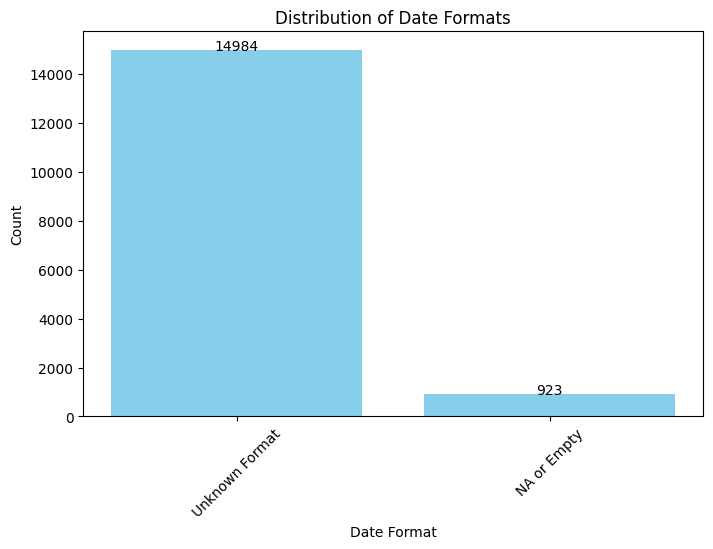

In [16]:
# Define regex patterns for different date formats
patterns = {
    'YYYY-MM-DD': r'^\d{4}-\d{2}-\d{2}$',  # ISO format
    'MMM D, YYYY': r'^[A-Za-z]{3} \d{1,2}, \d{4}$',  # Short month name
    'Month DD, YYYY': r'^[A-Za-z]+ \d{1,2}, \d{4}$',  # Full month name
    'YYYY': r'^\d{4}$',  # Year only
    'Datetime Format': r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}$',  # Full timestamp
    'NA or Empty': r'^(nan|NaT|NA)$'
}

# Function to classify date formats
def classify_format(date):
    for fmt, pattern in patterns.items():
        if re.match(pattern, date):
            return fmt
    return "Unknown Format"  # If it doesn't match known formats

# Apply classification
df['date_format'] = df['date'].apply(classify_format)

# Group the original dataset by date format
grouped_dfs = {fmt: df[df['date_format'] == fmt] for fmt in df['date_format'].unique()}

# Display each grouped DataFrame separately
for fmt, group_df in grouped_dfs.items():
    print(f"\nDate Format: {fmt}")
    display(group_df[['date']])  # Display only the date column

# Count occurrences of each format
format_counts = df['date_format'].value_counts().reset_index()
format_counts.columns = ['Date Format', 'Count']

# Visualize the results
plt.figure(figsize=(8, 5))
plt.bar(format_counts['Date Format'], format_counts['Count'], color='skyblue')
plt.xlabel('Date Format')
plt.ylabel('Count')
plt.title('Distribution of Date Formats')
plt.xticks(rotation=45)  # Rotate labels for readability


# Add count labels on top of bars
for index, value in enumerate(format_counts['Count']):
    plt.text(index, value + 1, str(value), ha='center', fontsize=10)
    
plt.show()


We can see that most of these follow the YYYY-MM-DD Format. We will fix the other format, and go back and individually input all of the NAs.

In [17]:
df["date"] = pd.to_datetime(
    df["date"],
    format="%Y-%m-%dT%H:%M:%S%z",  # or "%Y-%m-%dT%H:%M:%S.%f%z" if microseconds exist
    utc=True,                      # normalize to UTC
    errors="raise"                 # raise errors if parsing fails
)

df["date"] = df["date"].dt.strftime("%Y-%m-%d")
print(df)
print(df["date"].dtype)


                                                                                     url  \
0             https://www.fool.com/investing/2022/01/10/why-nvidia-stock-soared-in-2021/   
1             https://www.fool.com/investing/2022/01/10/why-nvidia-stock-soared-in-2021/   
2             https://www.fool.com/investing/2022/01/10/why-nvidia-stock-soared-in-2021/   
3             https://www.fool.com/investing/2022/01/10/why-nvidia-stock-soared-in-2021/   
4             https://www.fool.com/investing/2022/01/10/why-nvidia-stock-soared-in-2021/   
...                                                                                  ...   
15902  https://www.fool.com/investing/2025/02/16/where-will-nvidia-stock-be-in-10-years/   
15903  https://www.fool.com/investing/2025/02/16/where-will-nvidia-stock-be-in-10-years/   
15904  https://www.fool.com/investing/2025/02/16/where-will-nvidia-stock-be-in-10-years/   
15905  https://www.fool.com/investing/2025/02/16/where-will-nvidia-stock-be-in-1

Taking care of NA dates, we have to look to see if the url has the date posted within it. We will view the following:

In [18]:
# Filter rows where the date_format is 'NA or Empty'
nan_dates_df = df[df['date_format'] == 'NA or Empty']

# Sort the filtered DataFrame by the 'url' column
nan_dates_df = nan_dates_df.sort_values(by='url')

unique_urls = nan_dates_df['url'].nunique()
print("Unique URLs:", unique_urls)


Unique URLs: 33


We only have 21 URLS that produced NaN results. We can manually find these dates. First, we will get a full print of every single one of these URLS.

In [19]:
# Ensure Pandas doesn't truncate long strings
pd.set_option('display.max_colwidth', None)

# Extract unique URLs from the 'url' column and reset the index
unique_urls = nan_dates_df['url'].drop_duplicates().dropna().reset_index(drop=True)

# Print each URL with a numbered label
for i, url in enumerate(unique_urls, start=1):
    print(f"{i}. {url}")


1. https://discussion.fool.com/c/investment-analysis-clubs/8?page=1
2. https://www.fool.com/author/1301/
3. https://www.fool.com/author/20509/
4. https://www.fool.com/author/7018/
5. https://www.fool.com/investing/how-to-invest/famous-investors/elon-musk-investments/
6. https://www.fool.com/investing/stock-market/indexes/sp-500/
7. https://www.fool.com/investing/stock-market/market-sectors/communication/5g-stocks/
8. https://www.fool.com/investing/stock-market/market-sectors/energy/pipeline-stocks/
9. https://www.fool.com/investing/stock-market/market-sectors/healthcare/genomics-stocks/gene-editing-stocks/
10. https://www.fool.com/investing/stock-market/market-sectors/industrials/
11. https://www.fool.com/investing/stock-market/market-sectors/information-technology/advertising-tech/
12. https://www.fool.com/investing/stock-market/market-sectors/information-technology/cybersecurity-stocks/
13. https://www.fool.com/investing/stock-market/market-sectors/information-technology/semiconducto

**I went into these websites manually to find the dates: **

1. https://discussion.fool.com/c/investment-analysis-clubs/8?page=1 - 2025-02-20
2. https://www.fool.com/author/1301/ - Drop
3. https://www.fool.com/author/20509/ - Drop
4. https://www.fool.com/author/7018/ - Drop
5. https://www.fool.com/investing/how-to-invest/famous-investors/elon-musk-investments/ - 2024-05-16
6. https://www.fool.com/investing/stock-market/indexes/sp-500/ - 2025-02-12
7. https://www.fool.com/investing/stock-market/market-sectors/communication/5g-stocks/ - 2025-01-10
8. https://www.fool.com/investing/stock-market/market-sectors/energy/pipeline-stocks/ - 2024-09-13
9. https://www.fool.com/investing/stock-market/market-sectors/healthcare/genomics-stocks/gene-editing-stocks/ - 2023-07-03
10. https://www.fool.com/investing/stock-market/market-sectors/industrials/ - 2024-04-04
11. https://www.fool.com/investing/stock-market/market-sectors/information-technology/advertising-tech/ - 2024-08-21
12. https://www.fool.com/investing/stock-market/market-sectors/information-technology/cybersecurity-stocks/ - 2025-02-17
13. https://www.fool.com/investing/stock-market/market-sectors/information-technology/semiconductor-stocks/microchip-stocks/ - 2024-04-04
14. https://www.fool.com/investing/stock-market/market-sectors/materials/ - 2024-09-12
15. https://www.fool.com/legal/fool-disclosure/options/ - 2025-02-14
16. https://www.fool.com/quote/fra/ifx/ - 2025-02-20
17. https://www.fool.com/quote/fra/mvl/ - 2025-02-20
18. https://www.fool.com/quote/fra/nvd/ - 2025-02-20
19. https://www.fool.com/quote/nasdaq/aldx/ - 2025-02-20
20. https://www.fool.com/quote/nasdaq/areb/ - 2025-02-20
21. https://www.fool.com/quote/nasdaq/iren/ - 2025-02-20
22. https://www.fool.com/quote/nasdaq/megl/ - 2025-02-20
23. https://www.fool.com/quote/nasdaq/mksi/ - 2025-02-20
24. https://www.fool.com/quote/nasdaq/nvmi/ - 2025-02-20
25. https://www.fool.com/quote/nasdaq/pbts/ - 2025-02-20
26. https://www.fool.com/quote/nasdaq/poww/ - 2025-02-20
27. https://www.fool.com/quote/nasdaq/reit/ - 2025-02-20
28. https://www.fool.com/quote/nyse/abbv/ - 2025-02-20
29. https://www.fool.com/quote/nyse/smwb/ - 2025-02-20
30. https://www.fool.com/research/are-stock-splits-good/ - 2022-11-01
31. https://www.fool.com/research/largest-companies-by-market-cap/ 2025-02-03
32. https://www.fool.com/slideshow/13-signs-youre-ready-to-invest-in-the-stock-market/ - 2022-10-25
33. https://www.fool.com/terms/s/stock-split/ - 2024-10-23

In [20]:
# 1. Create a mapping of URL -> new date (or "Drop")
url_updates = {
    "https://discussion.fool.com/c/investment-analysis-clubs/8?page=1": "2025-02-20",
    "https://www.fool.com/author/1301/": "Drop",
    "https://www.fool.com/author/20509/": "Drop",
    "https://www.fool.com/author/7018/": "Drop",
    "https://www.fool.com/investing/how-to-invest/famous-investors/elon-musk-investments/": "2024-05-16",
    "https://www.fool.com/investing/stock-market/indexes/sp-500/": "2025-02-12",
    "https://www.fool.com/investing/stock-market/market-sectors/communication/5g-stocks/": "2025-01-10",
    "https://www.fool.com/investing/stock-market/market-sectors/energy/pipeline-stocks/": "2024-09-13",
    "https://www.fool.com/investing/stock-market/market-sectors/healthcare/genomics-stocks/gene-editing-stocks/": "2023-07-03",
    "https://www.fool.com/investing/stock-market/market-sectors/industrials/": "2024-04-04",
    "https://www.fool.com/investing/stock-market/market-sectors/information-technology/advertising-tech/": "2024-08-21",
    "https://www.fool.com/investing/stock-market/market-sectors/information-technology/cybersecurity-stocks/": "2025-02-17",
    "https://www.fool.com/investing/stock-market/market-sectors/information-technology/semiconductor-stocks/microchip-stocks/": "2024-04-04",
    "https://www.fool.com/investing/stock-market/market-sectors/materials/": "2024-09-12",
    "https://www.fool.com/legal/fool-disclosure/options/": "2025-02-14",
    "https://www.fool.com/quote/fra/ifx/": "2025-02-20",
    "https://www.fool.com/quote/fra/mvl/": "2025-02-20",
    "https://www.fool.com/quote/fra/nvd/": "2025-02-20",
    "https://www.fool.com/quote/nasdaq/aldx/": "2025-02-20",
    "https://www.fool.com/quote/nasdaq/areb/": "2025-02-20",
    "https://www.fool.com/quote/nasdaq/iren/": "2025-02-20",
    "https://www.fool.com/quote/nasdaq/megl/": "2025-02-20",
    "https://www.fool.com/quote/nasdaq/mksi/": "2025-02-20",
    "https://www.fool.com/quote/nasdaq/nvmi/": "2025-02-20",
    "https://www.fool.com/quote/nasdaq/pbts/": "2025-02-20",
    "https://www.fool.com/quote/nasdaq/poww/": "2025-02-20",
    "https://www.fool.com/quote/nasdaq/reit/": "2025-02-20",
    "https://www.fool.com/quote/nyse/abbv/": "2025-02-20",
    "https://www.fool.com/quote/nyse/smwb/": "2025-02-20",
    "https://www.fool.com/research/are-stock-splits-good/": "2022-11-01",
    "https://www.fool.com/research/largest-companies-by-market-cap/": "2025-02-03",
    "https://www.fool.com/slideshow/13-signs-youre-ready-to-invest-in-the-stock-market/": "2022-10-25",
    "https://www.fool.com/terms/s/stock-split/": "2024-10-23"
}

# 2. Loop over each URL in the mapping
for url, date_val in url_updates.items():
    if date_val == "Drop":
        # Remove rows matching this URL
        df = df[df['url'] != url]
    else:
        # Update the date for rows matching this URL
        df.loc[df['url'] == url, 'date'] = date_val

# 3. (Optional) Check how many rows remain and preview
print(f"DataFrame now has {len(df)} rows.")
print(df.head())


DataFrame now has 15860 rows.
                                                                          url  \
0  https://www.fool.com/investing/2022/01/10/why-nvidia-stock-soared-in-2021/   
1  https://www.fool.com/investing/2022/01/10/why-nvidia-stock-soared-in-2021/   
2  https://www.fool.com/investing/2022/01/10/why-nvidia-stock-soared-in-2021/   
3  https://www.fool.com/investing/2022/01/10/why-nvidia-stock-soared-in-2021/   
4  https://www.fool.com/investing/2022/01/10/why-nvidia-stock-soared-in-2021/   

         date  \
0  2022-01-10   
1  2022-01-10   
2  2022-01-10   
3  2022-01-10   
4  2022-01-10   

                                                                                                                                                                                                                                                                                                                                                                                            

1 Final check to ensure all the dates are formatted correctly:

In [21]:
# 3. Apply classification to the 'date' column
df['date_format'] = df['date'].astype(str).apply(classify_format)

# 4. Count occurrences of each format
format_counts = df['date_format'].value_counts().reset_index()
format_counts.columns = ['Date Format', 'Count']

# 5. Display the results
print(format_counts)

  Date Format  Count
0  YYYY-MM-DD  15860


## **Class Imbalances**
---
The following are to address class imbalances for the forbes pulled data:


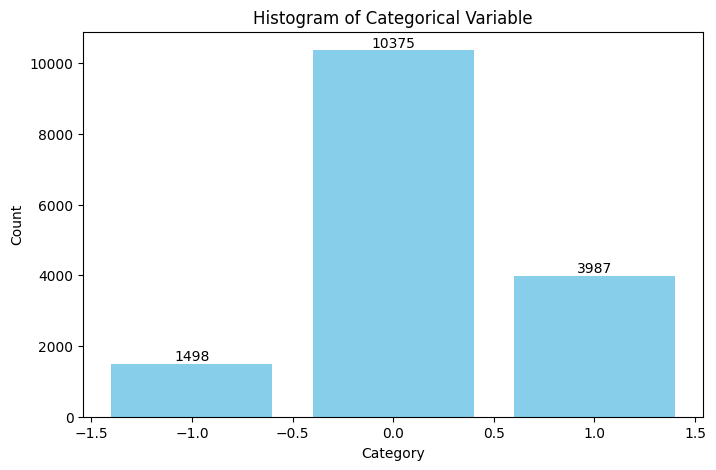

In [22]:
# Count occurrences of each category
category_counts = df['numeric_label'].value_counts()

# Plot histogram
plt.figure(figsize=(8,5))
bars = plt.bar(category_counts.index, category_counts.values, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Histogram of Categorical Variable')

# Add numeric labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{int(height)}', 
             ha='center', va='bottom', fontsize=10)

plt.show()


### Hotfix: Undersampling

We will be saving 2 seperate files therefore: an under-sampled file that contains equal parts of sentiment for all data (for immediate training), and the full, cleaned dataset, which we will prune later.

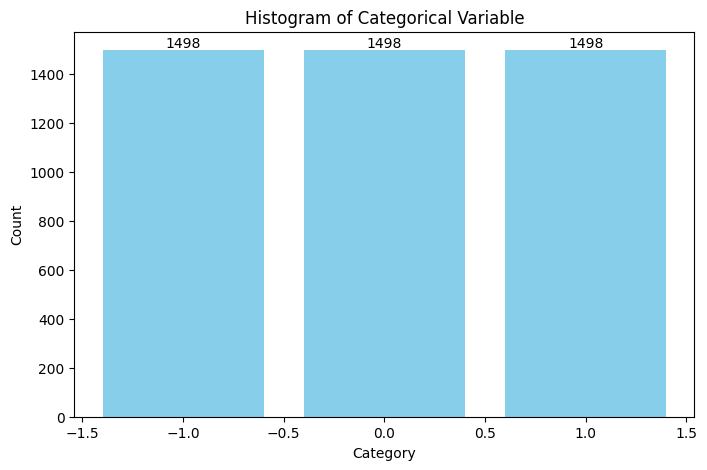

In [23]:


# 2. Undersample to balance classes
#    Let's assume your classes are in the column 'numeric_label'
class_counts = df['numeric_label'].value_counts()
min_count = class_counts.min()

# For each class, sample 'min_count' rows
balanced_dfs = []
for sentiment_value in class_counts.index:
    class_df = df[df['numeric_label'] == sentiment_value]
    class_df_undersampled = class_df.sample(n=min_count, random_state=42)
    balanced_dfs.append(class_df_undersampled)

# Combine them into a balanced DataFrame
df_undersampled = pd.concat(balanced_dfs).sample(frac=1, random_state=42).reset_index(drop=True)


category_counts = df_undersampled['numeric_label'].value_counts()

# Plot histogram
plt.figure(figsize=(8,5))
bars = plt.bar(category_counts.index, category_counts.values, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Histogram of Categorical Variable')

# Add numeric labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{int(height)}', 
             ha='center', va='bottom', fontsize=10)

plt.show()



In [ ]:
df.drop(columns=["date_format"], inplace=True)
df_undersampled.drop(columns=["date_format"], inplace=True)

df_undersampled.to_csv("sentiment_data_motley.csv", index=False)
df.to_csv("Scrutinize/nvda_sentence_sentiment_dataset_motley_cleaned.csv", index=False)
print("Files saved:\n- Scrutinize/nvda_sentence_sentiment_dataset_forbes_cleaned.csv (full dataset)\n- sentiment_data.csv (undersampled, balanced dataset)")


Files saved:
- Scrutinize/nvda_sentence_sentiment_dataset_forbes_cleaned.csv (full dataset)
- sentiment_data.csv (undersampled, balanced dataset)


# **Future Work:**
---
I will come back to the cleaned dataset and manually classify sentiment with a friend of mine in finance. We will then use this dataset to train sentiment instead of pre-trained Fin-BERT sentiments. This will take a while, and as we expand to more financial information, we will need to look into alternative methods.

### Current Help Needed:
---
If you can Work on 
 - data augmentation via synonym translation, back translating, and/or creating textual embeddings with the -1 and +1 samples of this dataset
 - Using SMOTE to create new data for -1 samples and +1 samples

That will be greatly appreciated.
